In [55]:
import pandas as pd
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
import numpy as np

## Import des données

In [56]:
data = pd.read_csv("csv/Questionnaires.csv",sep=";")

In [57]:
data.head()

,AGE,ID_NUM_TEL,SEXE,NIVEAU_SUPERIEUR_CHOIX,TYPE_TELEPHONE,ABONNEMENT_ILLIMITE,TEMPS_UTILISATION_SMS,ENVOI_SMS_SEMAINE,UTILISATION_T9,DESTINATAIRE_AMIS,DESTINATAIRE_COLLEGUES,DESTINATAIRE_FAMILLE,DESTINATAIRE_COMPAGNON,DUREE_LECTURE
0,16,202,Femme,lycee,classique,non,1 a 3,moins de 5,non,5,3,4,0,"4,19"
1,11,401,Homme,college,autre,oui,moins de 1,20 a 50,non,6,0,1,0,"5,24"
2,15,290,Homme,college,blackberry,non,1 a 3,plus de 100,oui,6,0,6,6,"3,14"
3,12,271,Homme,college,blackberry,oui,1 a 3,plus de 100,non,5,0,2,6,"1,05"
4,14,75,Femme,college,blackberry,oui,plus de 5,plus de 100,non,6,0,2,0,"6,29"


In [58]:
df = pd.read_csv("csv/BDD_sms.csv",sep=";")

In [59]:
df.head()

,NUM_SMS,ID_NUM_TEL,SMS_ANON
0,1,477,Hey ca va?\nAlors cette rentree?\nVa falloir s...
1,2,477,Ok super merci! Oui j'y comprends rien du tout...
2,3,477,Coucou !\nC'est quand la feria de Nimes?\nJ'su...
3,4,477,Coucou :)\nOui ca c'est bien passe!\nAlors je ...
4,5,477,On peut se rejoindre quelque part? Tu as cours...


## Fusion des deux dataframes par rapport à leur colonne ID_NUM_TEL

In [60]:
df = df.merge(data, how='left', on='ID_NUM_TEL')
df.head()

,NUM_SMS,ID_NUM_TEL,SMS_ANON,AGE,SEXE,NIVEAU_SUPERIEUR_CHOIX,TYPE_TELEPHONE,ABONNEMENT_ILLIMITE,TEMPS_UTILISATION_SMS,ENVOI_SMS_SEMAINE,UTILISATION_T9,DESTINATAIRE_AMIS,DESTINATAIRE_COLLEGUES,DESTINATAIRE_FAMILLE,DESTINATAIRE_COMPAGNON,DUREE_LECTURE
0,1,477,Hey ca va?\nAlors cette rentree?\nVa falloir s...,19,Femme,bac_1,blackberry,oui,plus de 5,20 a 50,non,6,0,5,6,"2,10"
1,2,477,Ok super merci! Oui j'y comprends rien du tout...,19,Femme,bac_1,blackberry,oui,plus de 5,20 a 50,non,6,0,5,6,"2,10"
2,3,477,Coucou !\nC'est quand la feria de Nimes?\nJ'su...,19,Femme,bac_1,blackberry,oui,plus de 5,20 a 50,non,6,0,5,6,"2,10"
3,4,477,Coucou :)\nOui ca c'est bien passe!\nAlors je ...,19,Femme,bac_1,blackberry,oui,plus de 5,20 a 50,non,6,0,5,6,"2,10"
4,5,477,On peut se rejoindre quelque part? Tu as cours...,19,Femme,bac_1,blackberry,oui,plus de 5,20 a 50,non,6,0,5,6,"2,10"


## On crée le corpus 'SEXE'

In [61]:
corpus_sexe = df[["SMS_ANON","SEXE"]] # on prend le sexe et le sms de la personne 
corpus_Femme=corpus_sexe.query("SEXE=='Femme'")
corpus_Homme=corpus_sexe.query("SEXE=='Homme'")

In [62]:
corpus_sexe.head()

,SMS_ANON,SEXE
0,Hey ca va?\nAlors cette rentree?\nVa falloir s...,Femme
1,Ok super merci! Oui j'y comprends rien du tout...,Femme
2,Coucou !\nC'est quand la feria de Nimes?\nJ'su...,Femme
3,Coucou :)\nOui ca c'est bien passe!\nAlors je ...,Femme
4,On peut se rejoindre quelque part? Tu as cours...,Femme


In [63]:
corpus_Femme.head()

,SMS_ANON,SEXE
0,Hey ca va?\nAlors cette rentree?\nVa falloir s...,Femme
1,Ok super merci! Oui j'y comprends rien du tout...,Femme
2,Coucou !\nC'est quand la feria de Nimes?\nJ'su...,Femme
3,Coucou :)\nOui ca c'est bien passe!\nAlors je ...,Femme
4,On peut se rejoindre quelque part? Tu as cours...,Femme


In [64]:
corpus_Homme.head()

,SMS_ANON,SEXE
12,Coucou! T'es pas la alors ce weekend? Et es-ce...,Homme
40,Coucou mon coeur je vais appeler le banquier. ...,Homme
43,Hello ! La rentrée est bien passée j'ai que 3 ...,Homme
44,Tu m'appelles pas? T'as eu mon texto? Tu finis...,Homme
45,C'est pas grave pour les schoumi-Gateau une au...,Homme


## On crée le corpus 'AGE'

In [65]:
from matplotlib import pyplot as plt
age = df["AGE"]

In [66]:
bins= [0,16.5,18.5,20.5,22.5,24.5,100] # Interval d'ages 
labels = [1,2,3,4,5,6] # Catégorie 
df["Agegroup"]=pd.cut(df['AGE'], bins=bins, labels=labels, right=False) # On crée une nouvelle colonnes avec les catégories

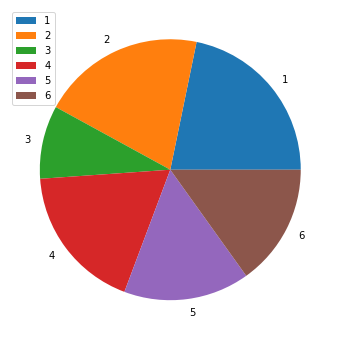

In [67]:
compte = df.groupby(["Agegroup"]).count() 
compte.plot.pie(y='ID_NUM_TEL', figsize=(6, 6)) 
plt.ylabel("")
plt.show()

In [68]:
corpus_age = df[["SMS_ANON","AGE","Agegroup"]] # Selection des bonnes colonnes 
corpus_age1=corpus_age.query('Agegroup==1')
corpus_age2=corpus_age.query('Agegroup==2')
corpus_age3=corpus_age.query('Agegroup==3')
corpus_age4=corpus_age.query('Agegroup==4')
corpus_age5=corpus_age.query('Agegroup==5')

In [78]:
corpus_age1.head()

,SMS_ANON,AGE,Agegroup
12,Coucou! T'es pas la alors ce weekend? Et es-ce...,15,1
115,"C'est bon, j'ai envoyé la lettre lol",15,1
116,"Coucou! Dis moi, tu vas faire la fete médiéval...",15,1
122,"Géniale, on la fera ensemble? :d",15,1
124,"Berk, j'aime pas la musique, j'ai été traumati...",15,1


## On crée le corpus 'TELEPHONE'

In [69]:
corpus_telephone = df[["SMS_ANON","TYPE_TELEPHONE"]]  # on prend le type de téléphone et le sms de la personne 
corpus_telephone.head()

,SMS_ANON,TYPE_TELEPHONE
0,Hey ca va?\nAlors cette rentree?\nVa falloir s...,blackberry
1,Ok super merci! Oui j'y comprends rien du tout...,blackberry
2,Coucou !\nC'est quand la feria de Nimes?\nJ'su...,blackberry
3,Coucou :)\nOui ca c'est bien passe!\nAlors je ...,blackberry
4,On peut se rejoindre quelque part? Tu as cours...,blackberry


In [70]:
corpus_blackberry=corpus_telephone.query("TYPE_TELEPHONE =='blackberry'")
corpus_iphone=corpus_telephone.query("TYPE_TELEPHONE=='iphone'")
corpus_classique=corpus_telephone.query("TYPE_TELEPHONE=='classique'")
corpus_autre=corpus_telephone.query("TYPE_TELEPHONE=='autre'")

In [71]:
corpus_iphone.head()

,SMS_ANON,TYPE_TELEPHONE
40,Coucou mon coeur je vais appeler le banquier. ...,iphone
43,Hello ! La rentrée est bien passée j'ai que 3 ...,iphone
44,Tu m'appelles pas? T'as eu mon texto? Tu finis...,iphone
45,C'est pas grave pour les schoumi-Gateau une au...,iphone
46,Ok keep cool pr l'entreprise et tiens moi au j...,iphone


# Comptage des mots

### Listes des stop words en français

In [72]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emmaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
stop_words = set(stopwords.words('French'))

### Création d'un dataframe comptant les mots utilisés dans chaque corpus

In [79]:
from sklearn.feature_extraction.text import CountVectorizer

In [80]:
vect = CountVectorizer(stop_words=stop_words)

In [82]:
vect.fit(df["SMS_ANON"].values.astype('U')) # Création du bag of word

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words={'ai', 'aie', 'aient', 'aies', 'ait', 'as', 'au',
                            'aura', 'aurai', 'auraient', 'aurais', 'aurait',
                            'auras', 'aurez', 'auriez', 'aurions', 'aurons',
                            'auront', 'aux', 'avaient', 'avais', 'avait',
                            'avec', 'avez', 'aviez', 'avions', 'avons', 'ayant',
                            'ayante', 'ayantes', ...},
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Tokenization

In [84]:
F_word =  vect.transform(df[df["SEXE"]=='Femme']["SMS_ANON"].values.astype('U')) # tokenisation des sms venant des femmes
H_word =  vect.transform(df[df["SEXE"]=='Homme']["SMS_ANON"].values.astype('U')) # tokenisation des sms venant des hommes
age1_word =  vect.transform(df[df["Agegroup"]==1]["SMS_ANON"].values.astype('U')) # tokenisation des sms venant du groupe d'âge N°1
age2_word =  vect.transform(df[df["Agegroup"]==2]["SMS_ANON"].values.astype('U')) # tokenisation des sms venant du groupe d'âge N°2
age3_word =  vect.transform(df[df["Agegroup"]==3]["SMS_ANON"].values.astype('U')) # tokenisation des sms venant du groupe d'âge N°3
age4_word =  vect.transform(df[df["Agegroup"]==4]["SMS_ANON"].values.astype('U')) # tokenisation des sms venant du groupe d'âge N°4
age5_word =  vect.transform(df[df["Agegroup"]==5]["SMS_ANON"].values.astype('U')) # tokenisation des sms venant du groupe d'âge N°5
age6_word =  vect.transform(df[df["Agegroup"]==6]["SMS_ANON"].values.astype('U')) # tokenisation des sms venant du groupe d'âge N°6

In [86]:
tel1_word =  vect.transform(df[df["TYPE_TELEPHONE"]=='blackberry']["SMS_ANON"].values.astype('U')) 
# tokenisation des sms venant d'un téléphone blackberry
tel2_word =  vect.transform(df[df["TYPE_TELEPHONE"]=='iphone']["SMS_ANON"].values.astype('U')) 
# tokenisation des sms venant d'un téléphone iphone
tel3_word =  vect.transform(df[df["TYPE_TELEPHONE"]=='classique']["SMS_ANON"].values.astype('U')) 
# tokenisation des sms venant d'un téléphone classique
tel4_word =  vect.transform(df[df["TYPE_TELEPHONE"]=='autre']["SMS_ANON"].values.astype('U')) 
# tokenisation des sms venant d'un telephone type autre

In [88]:
tel1_word

<22510x38596 sparse matrix of type '<class 'numpy.int64'>'
	with 148800 stored elements in Compressed Sparse Row format>

## Comptage

In [89]:
### Tokenizationnb_F_word = F_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_F_word = F_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_H_word = H_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_age1_word = age1_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_age2_word = age2_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_age3_word = age3_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_age4_word = age4_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_age5_word = age5_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_age6_word = age6_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation

In [91]:
nb_F_word

<61607x38596 sparse matrix of type '<class 'numpy.int64'>'
	with 436145 stored elements in Compressed Sparse Row format>

In [92]:
nb_tel1_word = tel1_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_tel2_word = tel2_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_tel3_word = tel3_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
nb_tel4_word = tel4_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation

In [93]:
nb_tel1_word

matrix([[3, 6, 0, ..., 0, 1, 0]], dtype=int64)

In [94]:
df_F = pd.DataFrame(nb_F_word, columns=vect.get_feature_names()) # création d'un dataframe regroupant le comptage pour FEMME
df_H = pd.DataFrame(nb_H_word, columns=vect.get_feature_names()) # création d'un dataframe regroupant le comptage pour homme
df_age1 = pd.DataFrame(nb_age1_word, columns=vect.get_feature_names()) 
df_age2 = pd.DataFrame(nb_age2_word, columns=vect.get_feature_names()) 
df_age3 = pd.DataFrame(nb_age3_word, columns=vect.get_feature_names()) 
df_age4 = pd.DataFrame(nb_age4_word, columns=vect.get_feature_names()) 
df_age5 = pd.DataFrame(nb_age5_word, columns=vect.get_feature_names()) 
df_age6 = pd.DataFrame(nb_age6_word, columns=vect.get_feature_names())

In [97]:
df_age1

,00,000,002,007,00h,00h00,00h15,00h20,00h26,00h30,...,σε,τοι,τρες,τρυκ,τυ,τφαι,φοις,ωιλλ,ватаяъ,你好
0,4,1,0,0,0,3,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [95]:
df_tel1 = pd.DataFrame(nb_tel1_word, columns=vect.get_feature_names()) 
df_tel2 = pd.DataFrame(nb_tel2_word, columns=vect.get_feature_names()) 
df_tel3 = pd.DataFrame(nb_tel3_word, columns=vect.get_feature_names()) 
df_tel4 = pd.DataFrame(nb_tel4_word, columns=vect.get_feature_names())

In [96]:
df_tel1

,00,000,002,007,00h,00h00,00h15,00h20,00h26,00h30,...,σε,τοι,τρες,τρυκ,τυ,τφαι,φοις,ωιλλ,ватаяъ,你好
0,3,6,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Création d'un dataFrame pour l'ensemble des sous-corpus

In [99]:
frames = [df_F,df_H,df_age1,df_age2,df_age3,df_age4,df_age5,df_age6, df_tel1, df_tel2, df_tel3, df_tel4]
total_word = pd.concat(frames) # fusion des deux dataframes
total_word = total_word.reset_index(drop=True)
total_word=total_word.T
total_word = total_word.rename(columns={ total_word.columns[0]: "Femme",
                                        total_word.columns[1]: "Homme" ,
                                        total_word.columns[2]: "Age1",
                                        total_word.columns[3]: "Age2",
                                        total_word.columns[4]: "Age3",
                                        total_word.columns[5]: "Age4",
                                        total_word.columns[6]: "Age5",
                                        total_word.columns[7]: "Age6",
                                        total_word.columns[8]: "Tel1",
                                        total_word.columns[9]: "Tel2",
                                        total_word.columns[10]: "Tel3",
                                        total_word.columns[11]: "Tel4"}) # renommage des colonnes

In [101]:
total_word.head()

,Femme,Homme,Age1,Age2,Age3,Age4,Age5,Age6,Tel1,Tel2,Tel3,Tel4
00,7,7,4,0,0,0,1,9,3,11,0,0
000,11,8,1,4,1,4,5,4,6,6,7,0
002,1,0,0,0,0,1,0,0,0,0,1,0
007,0,1,0,0,0,1,0,0,0,1,0,0
00h,6,0,0,1,0,2,3,0,0,2,4,0


In [102]:
total_word.head(10)

,Femme,Homme,Age1,Age2,Age3,Age4,Age5,Age6,Tel1,Tel2,Tel3,Tel4
00,7,7,4,0,0,0,1,9,3,11,0,0
000,11,8,1,4,1,4,5,4,6,6,7,0
002,1,0,0,0,0,1,0,0,0,0,1,0
007,0,1,0,0,0,1,0,0,0,1,0,0
00h,6,0,0,1,0,2,3,0,0,2,4,0
00h00,2,3,3,0,0,1,0,1,2,2,0,1
00h15,1,0,0,0,0,0,1,0,0,0,1,0
00h20,1,0,0,0,1,0,0,0,0,0,0,1
00h26,1,0,0,0,0,0,0,1,0,0,1,0
00h30,1,0,0,0,0,0,1,0,0,0,1,0


### Fréquence des occurences

In [103]:
totaux=total_word.sum(axis=0)
totaux

Femme    453656
Homme    131458
Age1      99846
Age2     105278
Age3      52168
Age4     120637
Age5     103743
Age6     103442
Tel1     154800
Tel2     209738
Tel3     191692
Tel4      28884
dtype: int64

In [104]:
total_word["coeff_fem"] = total_word["Femme"] / totaux['Femme'] * 100
total_word["coeff_hom"] = total_word["Homme"] / totaux['Homme'] * 100
total_word["coeff_age1"] = total_word["Age1"] / totaux['Age1'] * 100
total_word["coeff_age2"] = total_word["Age2"] / totaux['Age2'] * 100
total_word["coeff_age3"] = total_word["Age3"] / totaux['Age3'] * 100
total_word["coeff_age4"] = total_word["Age4"] / totaux['Age4'] * 100
total_word["coeff_age5"] = total_word["Age5"] / totaux['Age5'] * 100
total_word["coeff_age6"] = total_word["Age6"] / totaux['Age6'] * 100
total_word["coeff_tel1"] = total_word["Tel1"] / totaux['Tel1'] * 100
total_word["coeff_tel2"] = total_word["Tel2"] / totaux['Tel2'] * 100
total_word["coeff_tel3"] = total_word["Tel3"] / totaux['Tel3'] * 100
total_word["coeff_tel4"] = total_word["Tel4"] / totaux['Tel4'] * 100


total_word.head()

,Femme,Homme,Age1,Age2,Age3,Age4,Age5,Age6,Tel1,Tel2,...,coeff_age1,coeff_age2,coeff_age3,coeff_age4,coeff_age5,coeff_age6,coeff_tel1,coeff_tel2,coeff_tel3,coeff_tel4
00,7,7,4,0,0,0,1,9,3,11,...,0.004006,0.000000,0.000000,0.000000,0.000964,0.008701,0.001938,0.005245,0.000000,0.0
000,11,8,1,4,1,4,5,4,6,6,...,0.001002,0.003799,0.001917,0.003316,0.004820,0.003867,0.003876,0.002861,0.003652,0.0
002,1,0,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000829,0.000000,0.000000,0.000000,0.000000,0.000522,0.0
007,0,1,0,0,0,1,0,0,0,1,...,0.000000,0.000000,0.000000,0.000829,0.000000,0.000000,0.000000,0.000477,0.000000,0.0
00h,6,0,0,1,0,2,3,0,0,2,...,0.000000,0.000950,0.000000,0.001658,0.002892,0.000000,0.000000,0.000954,0.002087,0.0


### On peut maintenant afficher les mots les plus utilisés par une pop

In [105]:
total_word.sort_values("coeff_fem",ascending = False).head(10)

,Femme,Homme,Age1,Age2,Age3,Age4,Age5,Age6,Tel1,Tel2,...,coeff_age1,coeff_age2,coeff_age3,coeff_age4,coeff_age5,coeff_age6,coeff_tel1,coeff_tel2,coeff_tel3,coeff_tel4
ça,6454,1171,1425,1292,347,2821,1043,697,2468,2462,...,1.427198,1.227227,0.665159,2.338420,1.005369,0.673808,1.594315,1.173845,1.155499,1.661820
oui,4909,1001,930,1149,541,977,1435,878,1222,2025,...,0.931434,1.091396,1.037034,0.809868,1.383226,0.848785,0.789406,0.965490,1.197233,1.274062
si,4894,1426,1024,1183,614,1310,1135,1054,1664,2338,...,1.025579,1.123692,1.176967,1.085902,1.094050,1.018928,1.074935,1.114724,1.065772,0.952084
va,4818,1321,898,1119,619,1298,1134,1071,1490,2262,...,0.899385,1.062900,1.186551,1.075955,1.093086,1.035363,0.962532,1.078488,1.084552,1.066334
bien,4421,1284,757,1100,534,1125,1072,1117,1371,2025,...,0.758168,1.044853,1.023616,0.932550,1.033323,1.079832,0.885659,0.965490,1.033429,1.135577
ca,4378,899,514,1574,755,665,1044,725,1813,1365,...,0.514793,1.495089,1.447247,0.551240,1.006333,0.700876,1.171189,0.650812,0.957265,0.914001
fait,4246,873,936,1111,453,1130,766,723,1453,1723,...,0.937444,1.055301,0.868348,0.936694,0.738363,0.698942,0.938630,0.821501,0.885274,0.851683
lol,4179,971,174,1372,326,1284,1136,858,1436,1315,...,0.174268,1.303216,0.624904,1.064350,1.095014,0.829450,0.927649,0.626973,1.133068,0.785902
non,3723,900,727,796,402,1211,948,539,1499,1519,...,0.728121,0.756093,0.770587,1.003838,0.913797,0.521065,0.968346,0.724237,0.759030,0.519319
plus,3566,981,798,933,440,1038,651,687,1425,1591,...,0.799231,0.886225,0.843429,0.860433,0.627512,0.664140,0.920543,0.758565,0.691735,0.709735


In [106]:
total_word.sort_values("coeff_hom",ascending = False).head(10)

,Femme,Homme,Age1,Age2,Age3,Age4,Age5,Age6,Tel1,Tel2,...,coeff_age1,coeff_age2,coeff_age3,coeff_age4,coeff_age5,coeff_age6,coeff_tel1,coeff_tel2,coeff_tel3,coeff_tel4
si,4894,1426,1024,1183,614,1310,1135,1054,1664,2338,...,1.025579,1.123692,1.176967,1.085902,1.094050,1.018928,1.074935,1.114724,1.065772,0.952084
va,4818,1321,898,1119,619,1298,1134,1071,1490,2262,...,0.899385,1.062900,1.186551,1.075955,1.093086,1.035363,0.962532,1.078488,1.084552,1.066334
bien,4421,1284,757,1100,534,1125,1072,1117,1371,2025,...,0.758168,1.044853,1.023616,0.932550,1.033323,1.079832,0.885659,0.965490,1.033429,1.135577
ça,6454,1171,1425,1292,347,2821,1043,697,2468,2462,...,1.427198,1.227227,0.665159,2.338420,1.005369,0.673808,1.594315,1.173845,1.155499,1.661820
oui,4909,1001,930,1149,541,977,1435,878,1222,2025,...,0.931434,1.091396,1.037034,0.809868,1.383226,0.848785,0.789406,0.965490,1.197233,1.274062
plus,3566,981,798,933,440,1038,651,687,1425,1591,...,0.799231,0.886225,0.843429,0.860433,0.627512,0.664140,0.920543,0.758565,0.691735,0.709735
bon,3350,980,611,745,368,935,889,782,1264,1431,...,0.611942,0.707650,0.705413,0.775052,0.856925,0.755979,0.816537,0.682280,0.759030,0.623182
lol,4179,971,174,1372,326,1284,1136,858,1436,1315,...,0.174268,1.303216,0.624904,1.064350,1.095014,0.829450,0.927649,0.626973,1.133068,0.785902
tout,2947,934,713,732,446,895,536,559,1102,1475,...,0.714100,0.695302,0.854930,0.741895,0.516661,0.540399,0.711886,0.703258,0.583749,0.640493
non,3723,900,727,796,402,1211,948,539,1499,1519,...,0.728121,0.756093,0.770587,1.003838,0.913797,0.521065,0.968346,0.724237,0.759030,0.519319


### Traitement du sms d'entrée

In [107]:

sms=["Odysséum ? Non mais j'ai pas le temps désolée :S j'vais le transférerà <PRE_7> mais moi je vais en ville acheter le pass et j'avais dis à ma pote depuis un moment qu'on se voyait aujourd'hui A ce soir, bisou <PRE_1>."]

In [108]:
sms_word =  vect.transform(sms) # tokenisation du nouvel sms
nb_sms_word = sms_word.sum(axis = 0) # On compte pour chaque mots son nombre utilisation
df_sms = pd.DataFrame(nb_sms_word, columns=vect.get_feature_names()) 
df_sms=df_sms.T
df_sms = df_sms.rename(columns={ df_sms.columns[0]: "New"}) 
tot=df_sms.sum(axis=0)
df_sms["coeff_new"] = df_sms["New"] / tot['New'] * 100
df_sms.sort_values("coeff_new",ascending = False).head(10)

,New,coeff_new
vais,2,9.523810
acheter,1,4.761905
voyait,1,4.761905
désolée,1,4.761905
transférerà,1,4.761905
pre_7,1,4.761905
aujourd,1,4.761905
non,1,4.761905
pass,1,4.761905
odysséum,1,4.761905


In [109]:
final=total_word.iloc[:,8:]
final['new_sms']=df_sms["coeff_new"]
#final['index'] = final.index
final.head()

final.corr()

,Tel1,Tel2,Tel3,Tel4,coeff_fem,coeff_hom,coeff_age1,coeff_age2,coeff_age3,coeff_age4,coeff_age5,coeff_age6,coeff_tel1,coeff_tel2,coeff_tel3,coeff_tel4,new_sms
Tel1,1.000000,0.900211,0.935537,0.913310,0.965227,0.945227,0.852722,0.963737,0.924199,0.957540,0.907645,0.836953,1.000000,0.900211,0.935537,0.913310,0.158512
Tel2,0.900211,1.000000,0.919034,0.871299,0.970331,0.927116,0.918780,0.909401,0.928147,0.898625,0.882750,0.931232,0.900211,1.000000,0.919034,0.871299,0.163995
Tel3,0.935537,0.919034,1.000000,0.910246,0.973618,0.960380,0.807560,0.958704,0.939372,0.930659,0.980101,0.901337,0.935537,0.919034,1.000000,0.910246,0.141875
Tel4,0.913310,0.871299,0.910246,1.000000,0.930451,0.893664,0.820347,0.909628,0.894894,0.909109,0.877243,0.823308,0.913310,0.871299,0.910246,1.000000,0.116567
coeff_fem,0.965227,0.970331,0.973618,0.930451,1.000000,0.952393,0.888313,0.964824,0.951181,0.957703,0.940493,0.916456,0.965227,0.970331,0.973618,0.930451,0.154871
coeff_hom,0.945227,0.927116,0.960380,0.893664,0.952393,1.000000,0.845270,0.949546,0.945995,0.905722,0.945913,0.887679,0.945227,0.927116,0.960380,0.893664,0.161824
coeff_age1,0.852722,0.918780,0.807560,0.820347,0.888313,0.845270,1.000000,0.823745,0.832215,0.812881,0.776014,0.738571,0.852722,0.918780,0.807560,0.820347,0.135730
coeff_age2,0.963737,0.909401,0.958704,0.909628,0.964824,0.949546,0.823745,1.000000,0.946425,0.909382,0.925669,0.865301,0.963737,0.909401,0.958704,0.909628,0.138308
coeff_age3,0.924199,0.928147,0.939372,0.894894,0.951181,0.945995,0.832215,0.946425,1.000000,0.871023,0.913163,0.886247,0.924199,0.928147,0.939372,0.894894,0.152226
coeff_age4,0.957540,0.898625,0.930659,0.909109,0.957703,0.905722,0.812881,0.909382,0.871023,1.000000,0.887457,0.851872,0.957540,0.898625,0.930659,0.909109,0.157216


In [110]:

import numpy as np
import scipy.stats

corrF=scipy.stats.pearsonr(final['new_sms'], final['coeff_fem'])    # corr avec sms des femmes
corrH=scipy.stats.pearsonr(final['new_sms'], final['coeff_hom'])    # corr avec sms des hommes

max_sexe=max(corrF[0],corrH[0])
if corrF[0]==max_sexe:
    print("tu es une femme!")
else:
  print("tu es un homme!")

tu es un homme!


In [111]:
corr_age1=scipy.stats.pearsonr(final['new_sms'], final['coeff_age1'])    # corr avec sms age1
corr_age2=scipy.stats.pearsonr(final['new_sms'], final['coeff_age2'])    # corr avec sms age2
corr_age3=scipy.stats.pearsonr(final['new_sms'], final['coeff_age3'])    # corr avec sms age3
corr_age4=scipy.stats.pearsonr(final['new_sms'], final['coeff_age4'])    # corr avec sms age4
corr_age5=scipy.stats.pearsonr(final['new_sms'], final['coeff_age5'])    # corr avec sms age5
corr_age6=scipy.stats.pearsonr(final['new_sms'], final['coeff_age6'])    # corr avec sms age6

max_age=max(corr_age1[0],corr_age2[0],corr_age3[0],corr_age4[0],corr_age5[0],corr_age6[0])
if corr_age1[0]==max_age:
    print("tu as moins de 17 ans")
elif corr_age2[0]==max_age:
  print("tu as 17 ou 18 ans")
elif corr_age3[0]==max_age:
  print("tu as 19 ou 20 ans")
elif corr_age4[0]==max_age:
  print("tu as 21 ou 22 ans")
elif corr_age5[0]==max_age:
  print("tu as 23 ou 24 ans")
else:
  print("tu es vieux :O ^^")

tu as 21 ou 22 ans


In [113]:
final['diff_F']=final['new_sms']-final['coeff_fem']
final['diff_H']=final['new_sms']-final['coeff_hom']
final['diff_age1']=final['new_sms']-final['coeff_age1']
final['diff_age2']=final['new_sms']-final['coeff_age2']
final['diff_age3']=final['new_sms']-final['coeff_age3']
final['diff_age4']=final['new_sms']-final['coeff_age4']
final['diff_age5']=final['new_sms']-final['coeff_age5']
final['diff_age6']=final['new_sms']-final['coeff_age6']
final['diff_tel1']=final['new_sms']-final['coeff_tel1']
final['diff_tel2']=final['new_sms']-final['coeff_tel2']
final['diff_tel3']=final['new_sms']-final['coeff_tel3']
final['diff_tel4']=final['new_sms']-final['coeff_tel4']
final2=final.iloc[:,13:]
final2.head()

,coeff_tel2,coeff_tel3,coeff_tel4,new_sms,diff_F,diff_H,diff_age1,diff_age2,diff_age3,diff_age4,diff_age5,diff_age6,diff_tel1,diff_tel2,diff_tel3,diff_tel4
00,0.005245,0.000000,0.0,0.0,-0.001543,-0.005325,-0.004006,0.000000,0.000000,0.000000,-0.000964,-0.008701,-0.001938,-0.005245,0.000000,0.0
000,0.002861,0.003652,0.0,0.0,-0.002425,-0.006086,-0.001002,-0.003799,-0.001917,-0.003316,-0.004820,-0.003867,-0.003876,-0.002861,-0.003652,0.0
002,0.000000,0.000522,0.0,0.0,-0.000220,0.000000,0.000000,0.000000,0.000000,-0.000829,0.000000,0.000000,0.000000,0.000000,-0.000522,0.0
007,0.000477,0.000000,0.0,0.0,0.000000,-0.000761,0.000000,0.000000,0.000000,-0.000829,0.000000,0.000000,0.000000,-0.000477,0.000000,0.0
00h,0.000954,0.002087,0.0,0.0,-0.001323,0.000000,0.000000,-0.000950,0.000000,-0.001658,-0.002892,0.000000,0.000000,-0.000954,-0.002087,0.0


In [114]:
comp=final2.sum(axis=0)
comp

coeff_tel2    1.000000e+02
coeff_tel3    1.000000e+02
coeff_tel4    1.000000e+02
new_sms       1.000000e+02
diff_F       -4.802071e-12
diff_H       -2.284111e-12
diff_age1    -1.120661e-12
diff_age2    -4.428814e-13
diff_age3    -1.337835e-12
diff_age4     2.553289e-12
diff_age5    -2.006471e-12
diff_age6     1.816157e-12
diff_tel1     2.337724e-12
diff_tel2    -6.067004e-12
diff_tel3    -4.826154e-12
diff_tel4    -2.830791e-13
dtype: float64